## Índice

- [4.a. Atualização](#4.a.-Atualização)
- [4.b. Preenchimento e consistência](#4.b.-Preenchimento-e-consistência)
- [5. Taxa de ocupação dos leitos de UTI](#5.-Taxa-de-ocupação-dos-leitos-de-uti)
    - [5.b. Comparação com painéis estaduais](#5.b.-Comparação-com-Painéis-Estaduais)
- [6. Quantidade de leitos de UTI existentes](#6.-Quantidade-de-leitos-de-UTI-existentes)

### Outros links
- [data-quality-numbers](#data-quality-numbers)

## Todo

- comparar leitos cnes com leitos api, ver se está muito fora
- medidas de desatualização por estado e tipo de gestão

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timezone, timedelta
import time
import glob
import gzip
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from helpers.charts import plot_barh, plot_heatmap
import helpers.charts as charts

In [3]:
from helpers.preprocess_data import preprocess_data

## Ler dados

In [4]:
DATA_FOLDER = 'data/leitos/'
UPDATED_DAYS = [1, 2, 7, 14, 60, 90]

In [5]:
# data_files = glob.glob(f'{DATA_FOLDER}data_*.json.gz')
data_files = glob.glob(f'{DATA_FOLDER}data_*.csv.gz')
data_files.sort(reverse=True)
DATA_FILE = data_files[0]
print(DATA_FILE)

data/leitos/data_2021-03-23.csv.gz


In [6]:
# df = pd.read_csv(DATA_FILE)
df = pd.read_csv('data/leitos/data_2021-03-23.csv.gz')
TS_RUN = pd.to_datetime(df.iloc[0]['ts_run'])
print(TS_RUN)

2021-03-23 16:00:16.303915+00:00


In [7]:
df.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run'],
      dtype=object)

### Preprocessar dados

In [8]:
df_hb = preprocess_data(df, UPDATED_DAYS, TS_RUN)

## 4. Análise sobre qualidade dos dados

In [36]:
# main metric to calculate outdated records
MAIN_DAYS = 2

In [37]:
# cnes errors
df_hb['no_cnes_name'] = np.where(df_hb.nomeCnes.isna(), True, False)
df_hb['no_cnes_code'] = np.where(df_hb.cnes.isna(), True, False)
df_hb['no_matching_cnes'] = np.where(df_hb.id.isna(), True, False)
cols_cnes = [
    'no_cnes_name',
    'no_matching_cnes',
    'deactivated',
]
df_hb['any_cnes_error'] = df_hb[cols_cnes].any(axis='columns')


# outdated errors
for d in UPDATED_DAYS:
    df_hb[f'not_updated_{d}d'] = np.where(df_hb[f'updated_{d}d'] == True, False, True)


# beds occupation errors
df_hb['icu_total_ocup_gt_offer'] = np.where((df_hb['totalOcupUti'] > df_hb['totalOfertaUti']) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_hosp_ocup_gt_offer'] = np.where((df_hb['ocupHospUti'] > df_hb['ofertaHospUti']) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_covid_ocup_gt_offer'] = np.where((df_hb['ocupSRAGUti'] > df_hb['ofertaSRAGUti']) & (df_hb.has_uti_proxy == True), True, False)

# beds occupation errors - considering a tolerance margin
tolerance = 1.2
# icu
# df_hb['icu_total_ocup_gt_offer_tolerance'] = np.where((df_hb['totalOcupUti'] >= (df_hb['totalOfertaUti'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_hosp_ocup_gt_offer_tolerance'] = np.where((df_hb['ocupHospUti'] >= (df_hb['ofertaHospUti'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_covid_ocup_gt_offer_tolerance'] = np.where((df_hb['ocupSRAGUti'] >= (df_hb['ofertaSRAGUti'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
# non icu
# df_hb['cli_total_ocup_gt_offer_tolerance'] = np.where((df_hb['totalOcupCli'] >= (df_hb['totalOfertaCli'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
df_hb['cli_hosp_ocup_gt_offer_tolerance'] = np.where((df_hb['ocupHospCli'] >= (df_hb['ofertaHospCli'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
df_hb['cli_covid_ocup_gt_offer_tolerance'] = np.where((df_hb['ocupSRAGCli'] >= (df_hb['ofertaSRAGCli'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)

cols_icu_ocup_tolerance = [
    'icu_hosp_ocup_gt_offer_tolerance',
    'icu_covid_ocup_gt_offer_tolerance',  
]
df_hb['any_icu_ocup_tolerance_error'] = df_hb[cols_icu_ocup_tolerance].any(axis='columns')

cols_all_ocup_tolerance = [
    'cli_hosp_ocup_gt_offer_tolerance',
    'cli_covid_ocup_gt_offer_tolerance',  
] + cols_icu_ocup_tolerance
df_hb['any_cli_icu_ocup_tolerance_error'] = df_hb[cols_all_ocup_tolerance].any(axis='columns')


# df_hb['bad_state_code'] = np.where(df_hb['estadoSigla_original'].str.islower(), True, False)


# considering any of these errors
cols_any_error = [
    'any_cnes_error',
    'any_cli_icu_ocup_tolerance_error',
    'any_icu_ocup_tolerance_error',
    f'not_updated_{str(MAIN_DAYS)}d',
]
df_hb['any_error'] = df_hb[cols_any_error].any(axis='columns')

### 4.a. Atualização

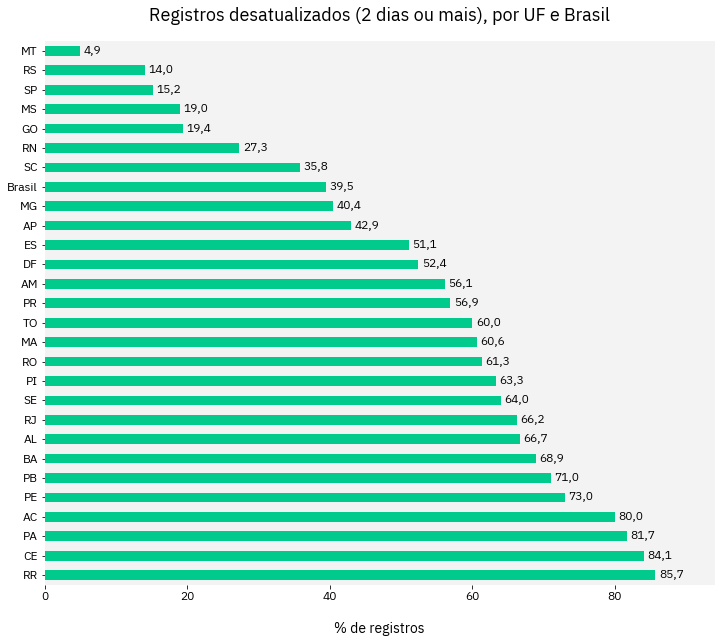

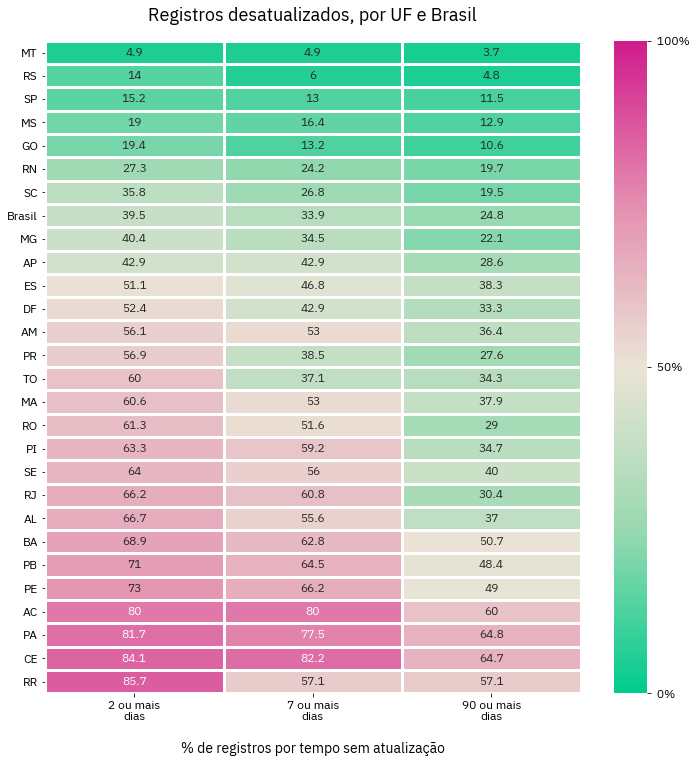

In [38]:
df_tmp = df_hb
# df_tmp = df_hb[df_hb.has_uti_proxy == True]

days = [2, 7, 90]
cols = [f'not_updated_{str(d)}d' for d in days]
xticklabels = [f'{str(d)} ou mais\ndias' for d in days]
main_col = f'not_updated_{str(MAIN_DAYS)}d'

by_state = df_tmp.groupby('estadoSigla')[cols].sum().div(df_tmp.groupby('estadoSigla')['cnes'].size(), axis=0)
country = df_tmp.groupby('_index')[cols].sum().div(df_tmp.groupby('_index')['cnes'].size(), axis=0)
country['estadoSigla'] = 'Brasil'
check = by_state.append(country.set_index('estadoSigla'))

plot_barh(check, main_col, round_pct=True, ascending=True,
         title=f'Registros desatualizados ({str(MAIN_DAYS)} dias ou mais), por UF e Brasil',
         xlabel='% de registros',
         figsize=(12,10),
         file_name='desatualizados_geral')

plot_heatmap(check.sort_values(main_col), cols, round_pct=True,
            xticklabels=xticklabels,
            title='Registros desatualizados, por UF e Brasil',
            xlabel='% de registros por tempo sem atualização',
            figsize=(12,12),
            file_name='desatualizados_tabela')

### 4.b. Preenchimento e consistência
#### data-quality-numbers

In [39]:
df_tmp = df_hb

quality_check_cols = [
    'any_error',
    'any_cnes_error',
    'no_cnes_name',
#     'no_cnes_code',
    'no_matching_cnes',
    'deactivated',
#     'icu_total_ocup_gt_offer_tolerance',
#     'icu_hosp_ocup_gt_offer_tolerance',
#     'icu_covid_ocup_gt_offer_tolerance',
#     'any_ocup_tolerance_error',
    f'not_updated_{str(MAIN_DAYS)}d',
#     'bad_state_code',
#     'any_icu_ocup_tolerance_error',
#     'icu_hosp_ocup_gt_offer',
#     'icu_covid_ocup_gt_offer',
    'any_cli_icu_ocup_tolerance_error',
]

# print('any_error:', round(df_tmp.set_index('cnes')[quality_check_cols].any(axis='columns').sum() / len(df_tmp) * 100, 1))

for col in quality_check_cols:
    print(f'{col}:', round(df_tmp.set_index('cnes')[[col]].any(axis='columns').sum() / len(df_tmp) * 100, 1))
    
df_uti = df_tmp[df_tmp.has_uti_proxy == True]
col = 'any_icu_ocup_tolerance_error'
print(f'{col}:', round(df_uti.set_index('cnes')[[col]].any(axis='columns').sum() / len(df_uti) * 100, 1))

any_error: 71.1
any_cnes_error: 14.8
no_cnes_name: 13.1
no_matching_cnes: 6.4
deactivated: 1.9
not_updated_2d: 39.5
any_cli_icu_ocup_tolerance_error: 42.7
any_icu_ocup_tolerance_error: 85.0


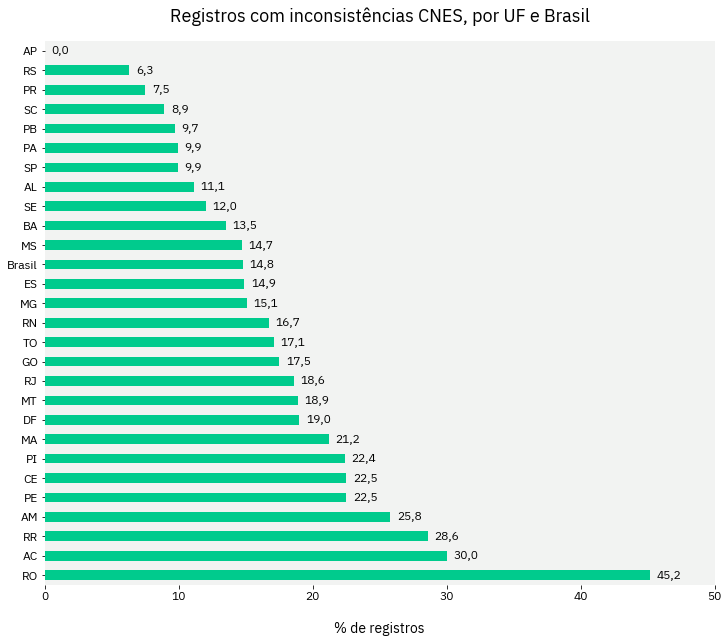

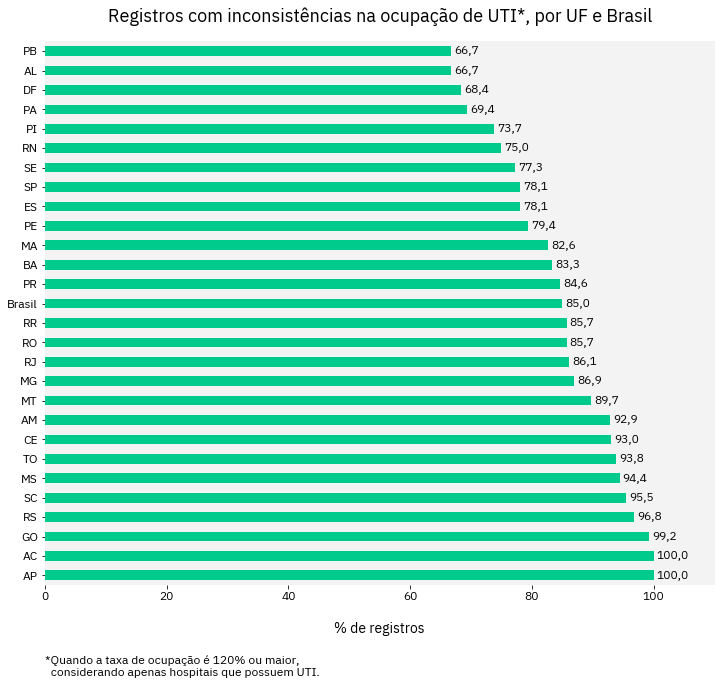

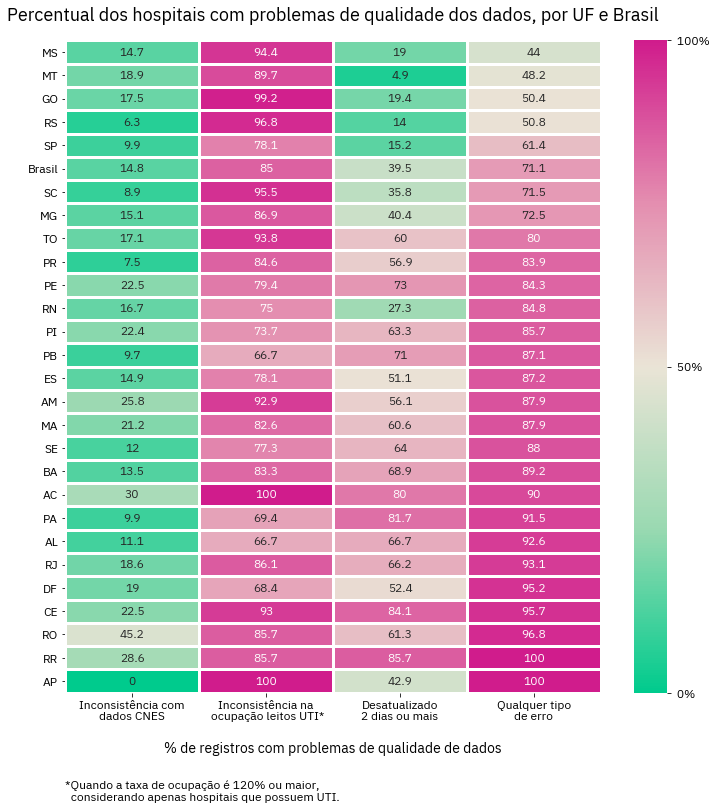

In [40]:
df_tmp = df_hb
df_uti = df_tmp[df_tmp.has_uti_proxy == True]

check_by_state = df_tmp.groupby('estadoSigla').agg({
    'any_error': 'sum',
    'any_cnes_error': 'sum',
#     'any_cli_icu_ocup_tolerance_error': 'sum',
    f'not_updated_{str(MAIN_DAYS)}d': 'sum'
}).div(df_tmp.groupby('estadoSigla')['cnes'].size(), axis=0)
 
check_by_state_uti = df_uti.groupby('estadoSigla').agg({
    'any_icu_ocup_tolerance_error': 'sum',
}).div(df_uti.groupby('estadoSigla')['cnes'].size(), axis=0)

country = df_tmp.groupby('_index').agg({
    'any_error': 'sum',
    'any_cnes_error': 'sum',
#     'any_cli_icu_ocup_tolerance_error': 'sum',
    f'not_updated_{str(MAIN_DAYS)}d': 'sum'
}).div(df_tmp.groupby('_index')['cnes'].size(), axis=0)

country_uti = df_uti.groupby('_index').agg({
    'any_icu_ocup_tolerance_error': 'sum',
}).div(df_uti.groupby('_index')['cnes'].size(), axis=0)

check_by_state = check_by_state.join(check_by_state_uti)
country = country.join(country_uti)
country['estadoSigla'] = 'Brasil'

check = check_by_state.append(country.set_index('estadoSigla'))
check = check.sort_values('any_error', ascending=True)

# plot
cols_order = [
    'any_cnes_error',
    'any_icu_ocup_tolerance_error',
    f'not_updated_{str(MAIN_DAYS)}d',
    'any_error',
]
xticklabels = [
    'Inconsistência com\ndados CNES',
    'Inconsistência na\n ocupação leitos UTI*',
    f'Desatualizado\n{str(MAIN_DAYS)} dias ou mais',
    'Qualquer tipo\nde erro',
]
# check['any_error'] = round(1 - check['any_error'], 2)

plot_barh(check, 'any_cnes_error', round_pct=True, ascending=True,
         title='Registros com inconsistências CNES, por UF e Brasil',
         xlabel='% de registros',
         figsize=(12,10),
         file_name='inconsistencia_cnes'
         )

plot_barh(check, 'any_icu_ocup_tolerance_error', round_pct=True, ascending=True,
         title='Registros com inconsistências na ocupação de UTI*, por UF e Brasil',
         xlabel='% de registros',
         figsize=(12,10),
         legend=f'*Quando a taxa de ocupação é {str(int(tolerance * 100))}% ou maior,\n  considerando apenas hospitais que possuem UTI.',
         legend_y=-0.15,
         file_name='inconsistencia_uti'
         )

plot_heatmap(check.sort_values('any_error'), cols_order, round_pct=True,
            xticklabels=xticklabels, cols_order=cols_order,
            title='Percentual dos hospitais com problemas de qualidade dos dados, por UF e Brasil',
            xlabel='% de registros com problemas de qualidade de dados',
            file_name='ranking_qualidade_tabela',
            legend=f'*Quando a taxa de ocupação é {str(int(tolerance * 100))}% ou maior,\n  considerando apenas hospitais que possuem UTI.',
            legend_y=-0.15,
            figsize=(12,12)
            )

### Desatualizados por estado e tipo de gestão

In [41]:
df_hb.groupby(['tpGestao', 'natJuridica']).size()

tpGestao  natJuridica
D         1.0             155
          2.0              29
          3.0             305
E         1.0             422
          2.0              42
          3.0             247
M         1.0            1266
          2.0             362
          3.0             793
          4.0               1
dtype: int64

In [42]:
types_natJuridica = {
    '1': 'ADMINISTRAÇÃO PÚBLICA',
    '2': 'ENTIDADES EMPRESARIAIS',
    '3': 'ENTIDADES SEM FINS LUCRATIVOS',
    '4': 'PESSOAS FÍSICAS', # claramente um erro 
}

types_tpGestao = {
    'D': 'Dupla',
    'E': 'Estadual',
    'M': 'Municipal',
}

<AxesSubplot:ylabel='estado,tpGestao'>

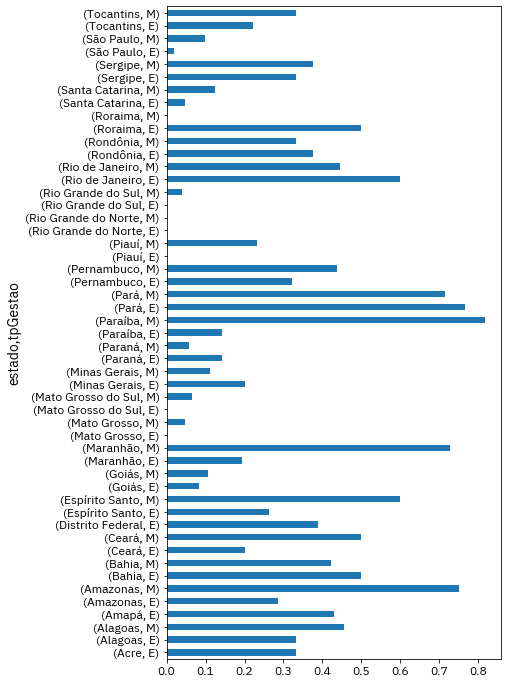

In [43]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_hb.has_uti_proxy == True) & (df_hb.tpGestao.isin(['M', 'E']))]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
).plot.barh(figsize=(6,12))

In [44]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_hb.has_uti_proxy == True) & (df_hb.tpGestao.isin(['M', 'E']))]

df_tmp = (df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
)

df_tmp.reset_index().groupby(['tpGestao']).mean()

,0
tpGestao,
E,0.303581
M,0.354078


## 5. Taxa de ocupação dos leitos de uti

In [45]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_hb.has_uti_proxy == True)]

agg = {
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
}

by_state = df_tmp.groupby('estadoSigla').agg(agg)

country = df_tmp.groupby('_index').agg(agg)
country['estadoSigla'] = 'Brasil'
by_state = by_state.append(country.set_index('estadoSigla'))

by_state['pct_occupied_total'] = by_state['totalOcupUti'] / by_state['totalOfertaUti']
by_state['pct_occupied_covid'] = by_state['ocupSRAGUti'] / by_state['ofertaSRAGUti']
by_state['pct_occupied_non_covid'] = by_state['ocupHospUti'] / by_state['ofertaHospUti']

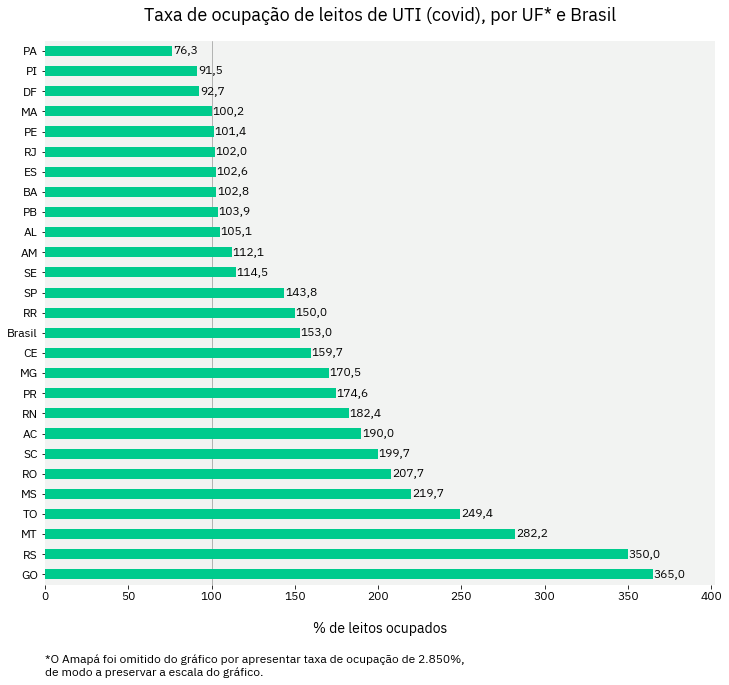

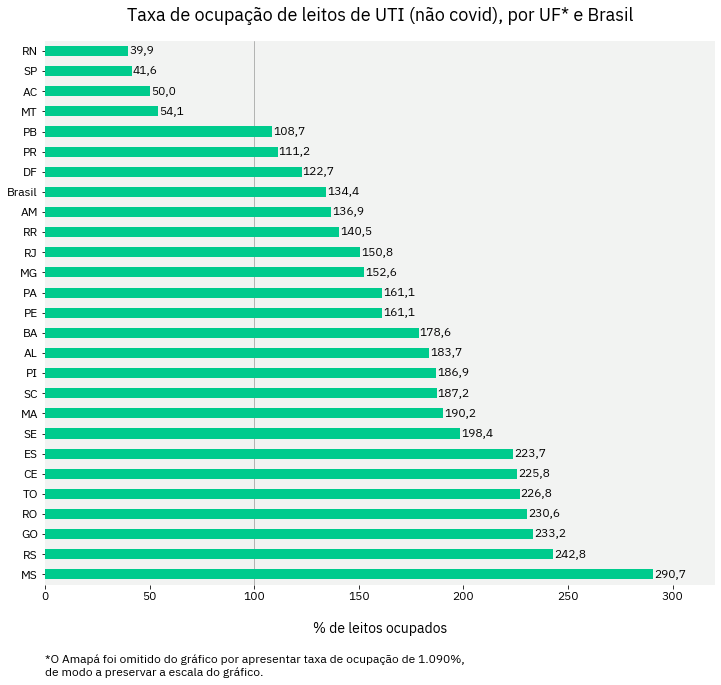

In [46]:
df_tmp = by_state[by_state['pct_occupied_total'] < 10]

plot_barh(df_tmp, 'pct_occupied_covid', round_pct=True, ascending=True,
         title='Taxa de ocupação de leitos de UTI (covid), por UF* e Brasil',
         xlabel='% de leitos ocupados',
         figsize=(12,10),
         file_name='taxa_ocupacao_leitos_covid',
         legend='*O Amapá foi omitido do gráfico por apresentar taxa de ocupação de 2.850%,\nde modo a preservar a escala do gráfico.',
         axvline=100,
         )

plot_barh(df_tmp, 'pct_occupied_non_covid', round_pct=True, ascending=True,
         title='Taxa de ocupação de leitos de UTI (não covid), por UF* e Brasil',
         xlabel='% de leitos ocupados',
         figsize=(12,10),
         file_name='taxa_ocupacao_leitos_nao_covid',
         legend='*O Amapá foi omitido do gráfico por apresentar taxa de ocupação de 1.090%,\nde modo a preservar a escala do gráfico.',
        axvline=100,
         )

### 5.b. Comparação com Painéis Estaduais

In [47]:
# dados secretarias estaduais
df_ses = pd.read_csv('ses/dados_secretarias.csv', sep=',')

df_ses['data_consulta'] = df_ses['ts_consulta'].str[:10]
df_ses['data'] = np.where(df_ses.data_autalizacao.notna(), df_ses.data_autalizacao, df_ses.data_consulta)

df_ses.head()

,estado,ts_consulta,data_autalizacao,hora_atualizacao,obs,fonte,fonte_url,uti_total_oferta,uti_total_bloquada,uti_total_ocupada,...,uti_covid_total_bloqueada,pct_uti_covid_total_ocupada,uti_covid_adulto_oferta,uti_covid_adulto_ocupada,pct_uti_covid_adulto_ocupada,uti_covid_pediatrica_oferta,uti_covid_pediatrica_ocupada,pct_uti_covid_pediatrica_ocupada,data_consulta,data
0,MT,2021-03-10 10:52:00,2021-03-09,17:37:39,NaN,"Painel Covid-19, Secretaria do Estado de Saúde...",http://www.saude.mt.gov.br/painelcovidmt2/,498.0,4.0,475.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-09
1,MA,2021-03-10 11:01:00,NaN,NaN,O painel é inconsistente internamente: em um l...,"Painel Coronavírus, Secretaria de Saúde",https://painel-covid19.saude.ma.gov.br/casos,NaN,NaN,NaN,...,NaN,0.853659,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-10
2,BA,2021-03-10 11:06:00,2021-03-09,19:22:00,NaN,Painel SEI Covid,https://infovis.sei.ba.gov.br/covid19/,NaN,NaN,NaN,...,NaN,0.867878,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-09
3,PA,2021-03-10 11:11:00,NaN,NaN,Leitos são “Somente gestão do Governo do Estad...,NaN,https://www.covid-19.pa.gov.br/#/,NaN,NaN,NaN,...,NaN,0.761616,487.0,373.0,0.765914,8.0,4.0,0.5,2021-03-10,2021-03-10
4,PB,2021-03-10 11:16:00,2021-03-10,11:00:13,NaN,Gestão de Leitos Covid-19 Paraíba,https://superset.plataformatarget.com.br/super...,NaN,NaN,NaN,...,NaN,0.803738,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-10


In [48]:
# estados sem dados
print('estados sem dados:', df_ses[(df_ses.uti_total_oferta.isna()) & (df_ses.uti_covid_total_oferta.isna())].estado.tolist())

estados sem dados: ['RJ']


In [49]:
df_ses.columns.values

array(['estado', 'ts_consulta', 'data_autalizacao', 'hora_atualizacao',
       'obs', 'fonte', 'fonte_url', 'uti_total_oferta',
       'uti_total_bloquada', 'uti_total_ocupada', 'pct_uti_total_ocupada',
       'uti_adulto_oferta', 'uti_adulto_bloqueada', 'uti_adulto_ocupada',
       'pct_uti_adulto_ocupada', 'uti_pediatrica_oferta',
       'uti_pediatrica_bloqueada', 'uti_pediatrica_ocupada',
       'pct_uti_pediatrica_ocupada', 'uti_covid_total_oferta',
       'uti_covid_total_ocupada', 'uti_covid_total_bloqueada',
       'pct_uti_covid_total_ocupada', 'uti_covid_adulto_oferta',
       'uti_covid_adulto_ocupada', 'pct_uti_covid_adulto_ocupada',
       'uti_covid_pediatrica_oferta', 'uti_covid_pediatrica_ocupada',
       'pct_uti_covid_pediatrica_ocupada', 'data_consulta', 'data'],
      dtype=object)

In [50]:
historic_file = f'{DATA_FOLDER}data_2021-03-09.csv.gz'
df_historic = pd.read_csv(historic_file)
TS_RUN_HISTORIC = pd.to_datetime(df.iloc[0]['ts_run'])
print(TS_RUN_HISTORIC)
df_historic = preprocess_data(df_historic, UPDATED_DAYS, TS_RUN_HISTORIC)

2021-03-23 16:00:16.303915+00:00


In [51]:
# calcular dados da api por estado, merge com dados secretarias estaduais
df_tmp = df_historic[(df_historic['deactivated_proxy'] == False) & (df_historic.has_uti_proxy == True)]
# df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()

by_state = df_tmp.groupby('estadoSigla').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
}).reset_index()

by_state_ses = by_state.merge(df_ses, left_on='estadoSigla', right_on='estado', how='left')

by_state_ses['diff_uti_total_oferta'] = (by_state_ses['totalOfertaUti'] / by_state_ses['uti_total_oferta']) - 1
by_state_ses['diff_uti_total_ocup'] = (by_state_ses['totalOcupUti'] / by_state_ses['uti_total_ocupada']) - 1
by_state_ses['diff_uti_total_oferta_alt'] = (by_state_ses['totalOfertaUtiAlt'] / by_state_ses['uti_total_oferta']) - 1
by_state_ses['diff_uti_covid_total_oferta'] = (by_state_ses['ofertaSRAGUti'] / by_state_ses['uti_covid_total_oferta']) - 1
by_state_ses['diff_uti_covid_total_ocup'] = (by_state_ses['ocupSRAGUti'] / by_state_ses['uti_covid_total_ocupada']) - 1

# taxas de ocupação
by_state_ses['pctTotalOcupUti'] = (by_state_ses['totalOcupUti'] / by_state_ses['totalOfertaUti'])
by_state_ses['pctSRAGOcupUti'] = (by_state_ses['ocupSRAGUti'] / by_state_ses['ofertaSRAGUti'])
by_state_ses['diff_pct_uti_total_ocupada'] = (by_state_ses['pctTotalOcupUti'] / by_state_ses['pct_uti_total_ocupada']) - 1
by_state_ses['diff_pct_uti_covid_total_ocupada'] = (by_state_ses['pctSRAGOcupUti'] / by_state_ses['pct_uti_covid_total_ocupada']) - 1

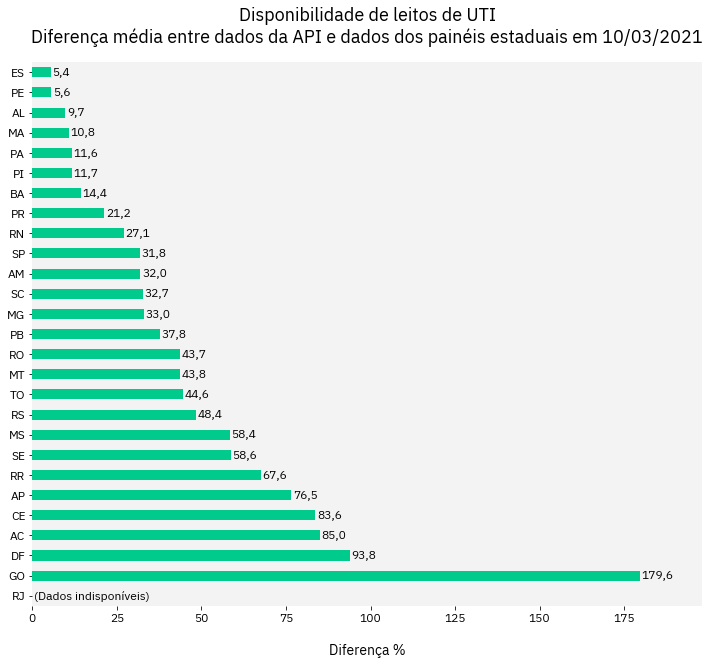

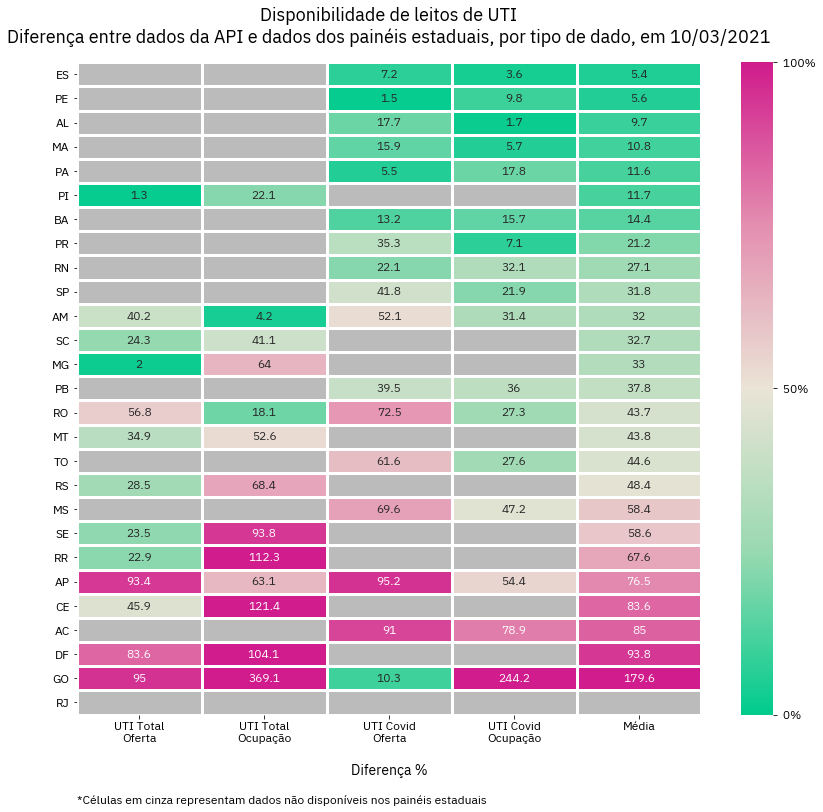

In [52]:
# diferença média por estado
cols = [
  'estadoSigla',
  'diff_uti_total_oferta',
  'diff_uti_total_ocup',
  'diff_uti_covid_total_oferta',
  'diff_uti_covid_total_ocup',
]
df_tmp = by_state_ses[cols].set_index('estadoSigla')
df_tmp = abs(df_tmp)
df_tmp = round(df_tmp * 100, 1)
df_mean = df_tmp.T.mean().sort_values(ascending=True)
# plot
df_chart = pd.DataFrame(df_mean)
df_chart.columns = ['mean']
plot_barh(df_chart, 'mean', round_pct=False, ascending=True,
         title='Disponibilidade de leitos de UTI\nDiferença média entre dados da API e dados dos painéis estaduais em 10/03/2021',
         xlabel='Diferença %',
         figsize=(12,10),
         file_name='diferenca_paineis_ses_media',
         zero_is_unavailable=True,
         )


# diferença por estado e por tipo de dado
# reorder to match df_mean order
df_heatmap = df_tmp.reindex(index=df_mean.reset_index()['estadoSigla'])
df_heatmap['diff_mean'] = round(df_mean, 1)
xticklabels = [
    'UTI Total\nOferta',
    'UTI Total\nOcupação',
    'UTI Covid\nOferta',
    'UTI Covid\nOcupação',
    'Média',
]
# plot
plot_heatmap(df_heatmap, df_heatmap.columns.values.tolist(), round_pct=False,
            xticklabels=xticklabels,
            title='Disponibilidade de leitos de UTI\nDiferença entre dados da API e dados dos painéis estaduais, por tipo de dado, em 10/03/2021',
            xlabel='Diferença %',
            figsize=(14,12),
            file_name='diferenca_paineis_ses_tabela',
            legend='*Células em cinza representam dados não disponíveis nos painéis estaduais',
            legend_y=-0.13,
            )

## 6. Quantidade de leitos de UTI existentes
#### (Comparação com leitos CNES)

<ipython-input-53-49889d2830de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()


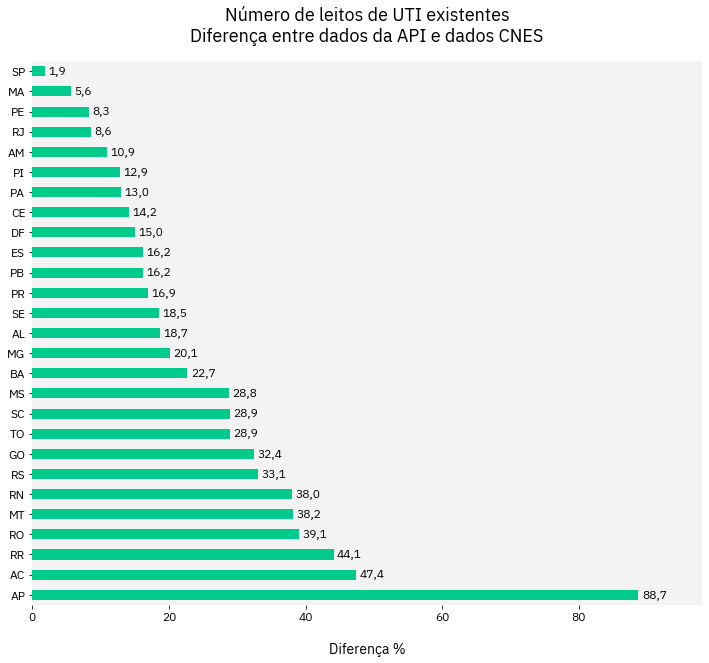

In [53]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_hb.has_uti_proxy == True)]
df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()

by_state = df_tmp.groupby('estadoSigla').agg({
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
}).reset_index()

df_tmp = by_state.set_index('estadoSigla')
df_tmp['diff_uti_total_oferta'] = abs((df_tmp['totalOfertaUti'] / df_tmp['uti_beds_via_cnes']) - 1)

plot_barh(df_tmp, 'diff_uti_total_oferta', round_pct=True, ascending=True,
         title='Número de leitos de UTI existentes\nDiferença entre dados da API e dados CNES',
         xlabel='Diferença %',
         figsize=(12,10),
         file_name='diferenca_leitos_cnes',
         )

## Comparação com série histórica

In [54]:
hist = pd.read_csv('data/2021-03-23_esus-vepi.LeitoOcupacao.zip')

/home/bpl/programming/sptrans-passengers-analysis/sptrans/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [55]:
hist.columns.values

array(['_id', 'dataNotificacao', 'cnes', 'ocupacaoSuspeitoCli',
       'ocupacaoSuspeitoUti', 'ocupacaoConfirmadoCli',
       'ocupacaoConfirmadoUti', 'saidaSuspeitaObitos',
       'saidaSuspeitaAltas', 'saidaConfirmadaObitos',
       'saidaConfirmadaAltas', 'origem', '_p_usuario',
       'estadoNotificacao', 'municipioNotificacao', 'estado', 'municipio',
       'excluido', 'validado', '_created_at', '_updated_at'], dtype=object)

In [56]:
len(hist)

721538

In [57]:
hist['dataNotificacao'] = pd.to_datetime(hist['dataNotificacao'])

<AxesSubplot:xlabel='dataNotificacao'>

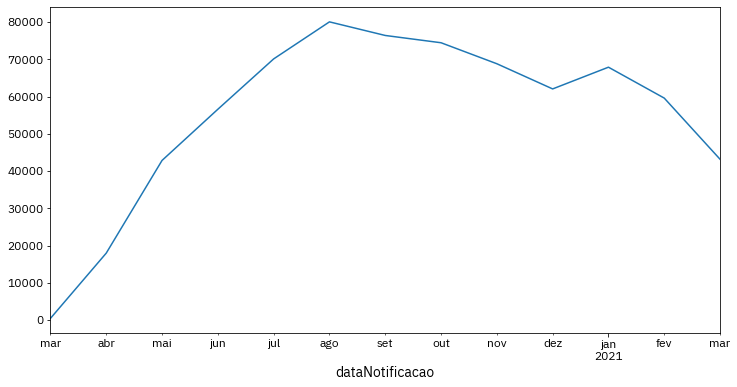

In [58]:
hist[hist['dataNotificacao'] >= '2020-03-01'].set_index('dataNotificacao').groupby(pd.Grouper(freq='M')).size().plot.line(figsize=(12,6))

In [59]:
len(hist[hist.excluido == True]) / len(hist)

0.0007040516230607397

In [60]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('---> dado série histórica \n')
    print(hist[(hist.cnes == 2080575)].sort_values('dataNotificacao', ascending=False)[10:11].iloc[0])

---> dado série histórica 

_id                                     Ji3gNob4Ho
dataNotificacao          2021-03-09 00:00:00+00:00
cnes                                       2080575
ocupacaoSuspeitoCli                              0
ocupacaoSuspeitoUti                              0
ocupacaoConfirmadoCli                           84
ocupacaoConfirmadoUti                           46
saidaSuspeitaObitos                              0
saidaSuspeitaAltas                               0
saidaConfirmadaObitos                            1
saidaConfirmadaAltas                             2
origem                                      RPA-SP
_p_usuario                        _User$HzwsO90KQW
estadoNotificacao                        São Paulo
municipioNotificacao                     São Paulo
estado                                   São Paulo
municipio                                São Paulo
excluido                                     False
validado                                     False
_cr

In [61]:
cols = [
    'cnes', 
    'nomeCnes',
    'dataNotificacaoOcupacao',
    'ofertaHospCli',
    'ofertaHospUti',
    'ofertaSRAGCli',
    'ofertaSRAGUti',
    'ocupHospCli',
    'ocupHospUti',
    'ocupSRAGCli',
    'ocupSRAGUti',
    'altas',
    'obitos'
]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('---> dado API\n')
    print(df[df.cnes == '2080575'][cols].iloc[0])

---> dado API

cnes                                        2080575
nomeCnes                                HOSPITAL BP
dataNotificacaoOcupacao    2021-03-22T00:00:00.000Z
ofertaHospCli                                   642
ofertaHospUti                                    65
ofertaSRAGCli                                     0
ofertaSRAGUti                                    20
ocupHospCli                                       0
ocupHospUti                                       0
ocupSRAGCli                                      95
ocupSRAGUti                                      64
altas                                            11
obitos                                            1
Name: 675, dtype: object


## Athena

```sql
CREATE EXTERNAL TABLE IF NOT EXISTS datalake_medidasp.leitos (
  hits:array<struct<
    `_index`:string,
    `_type`:string,
    `_id`:string,
    `_score`:string,
    `_source.estado`:string,
    `_source.estadosigla`:string,
    `_source.municipio`:string,
    `_source.cnes`:string,
    `_source.nomecnes`:string,
    `_source.datanotificacaoocupacao`:string,
    `_source.ofertarespiradores`:string,
    `_source.ofertahospcli`:string,
    `_source.ofertahosputi`:string,
    `_source.ofertasragcli`:string,
    `_source.ofertasraguti`:string,
    `_source.ocuphospcli`:string,
    `_source.ocuphosputi`:string,
    `_source.ocupsragcli`:string,
    `_source.ocupsraguti`:string,
    `_source.altas`:string,
    `_source.obitos`:string,
    `_source.ocupacaoinformada`:string,
    `_source.algumaocupacaoinformada`:string>> 
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES (
  'serialization.format' = '1'
) LOCATION 's3://medidasp/leitos/'
TBLPROPERTIES ('has_encrypted_data'='false');
```